In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from glob import glob
from typing import List
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocessing
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocessing
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocessing
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocessing
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.math import confusion_matrix
import tensorflow as tf

2024-01-17 16:56:48.246669: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-17 16:56:48.246699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-17 16:56:48.247886: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-17 16:56:48.254976: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 16:56:49.143002: W tensorflow/compiler/tf2

False

## Exploratory Data Analysis
### Visualize random samples

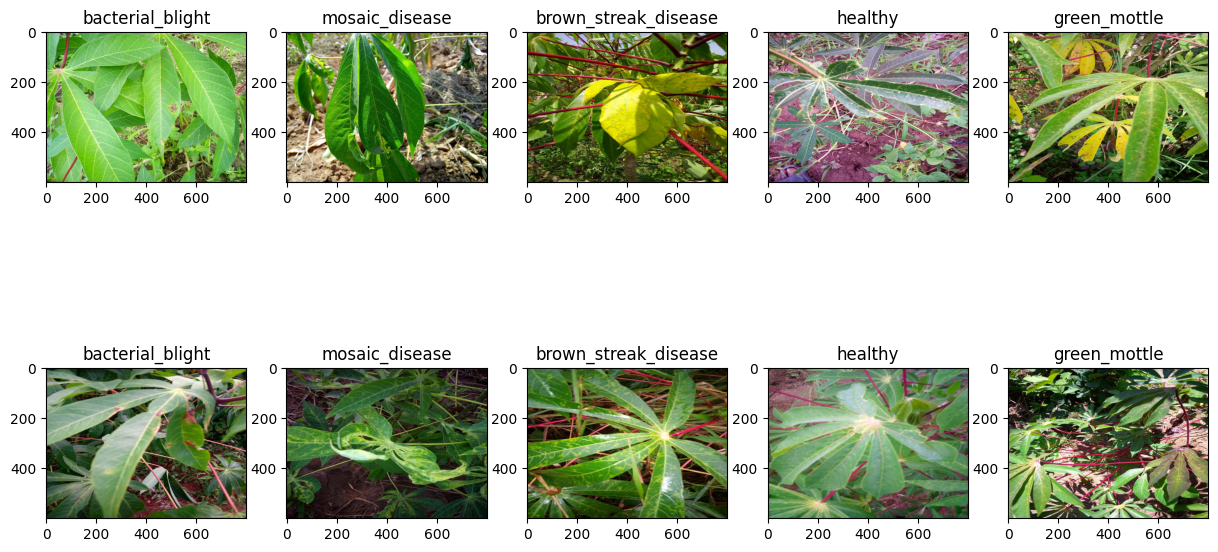

In [4]:
DATA_DIR = 'data'
# If using Kaggle notebook please comment above line and uncomment below line
# DATA_DIR = './kaggle/input/cassava-leaf-disease-classification/data'

class_names = os.listdir(DATA_DIR)

def visualize_images(image_paths: List[str]) -> None:
    """
    Function to visualize the images given by a list of image paths.
    :param image_paths: list of image paths
    :return: None
    """
    if len(image_paths) != 10:
        print("There should be 10 image paths provided in order to visualize two images from each class")
    else:
        max_rows = 2
        max_cols = 5
        # Create a figure and a set of subplots
        fig, axs = plt.subplots(max_rows, max_cols, figsize=(15,8))
        idx = 0
        for col in range(max_cols):
            for row in range(max_rows):
                img = cv2.imread(image_paths[idx])
                image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                class_name = image_paths[idx].split(os.sep)[-2]
                axs[row, col].imshow(image, )
                axs[row, col].set_title(class_name[10:])
                axs[row, col].grid(False)
                idx += 1
        # Set the padding between subplots
        # plt.subplots_adjust(hspace=2)
        plt.show()

# Select two random images from each class
image_paths = []
for class_name in class_names:
    paths = random.sample(glob(os.path.join(DATA_DIR, class_name)+os.sep+"*.jpg"), k=2)
    image_paths.extend(paths)
visualize_images(image_paths)

### Image resolution

In [5]:
# Take a random image
image = cv2.imread(image_paths[random.randint(0, len(image_paths)-1)])
print("Image shape (height, width, channels)")
print(image.shape)

Image shape (height, width, channels)
(600, 800, 3)


## Create DataFrame with image paths and labels
We create a dataframe that stores the image paths and labels and will be used for splitting the data, augmenting the data and even training.

In [6]:
image_paths = []
class_labels = []
for class_name in class_names:
    paths = glob(os.path.join(DATA_DIR, class_name) + os.sep + "*.jpg")
    image_paths.extend(paths)
    class_labels.extend([class_name]*len(paths))
df = pd.DataFrame(data={'image_path': image_paths, 'label': class_labels})

### Count images class wise
We also plot the count as a bar chart

label
Cassava___mosaic_disease          13158
Cassava___healthy                  2577
Cassava___green_mottle             2386
Cassava___brown_streak_disease     2189
Cassava___bacterial_blight         1087
Name: count, dtype: int64


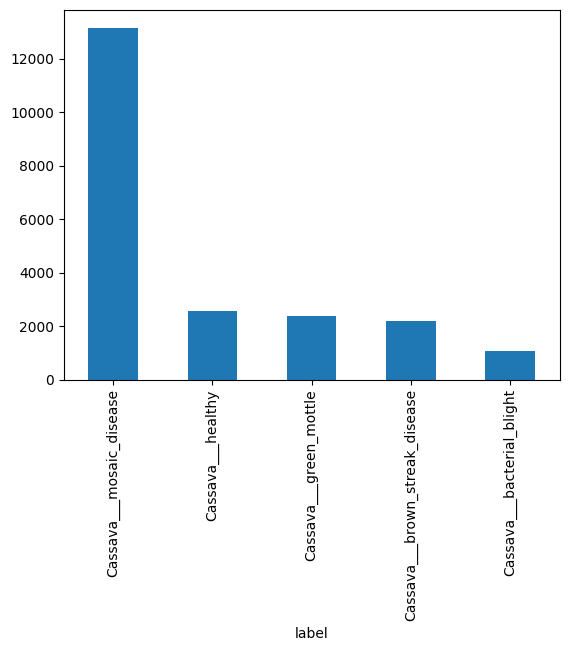

In [7]:
df['label'].value_counts().plot(kind='bar')
print(df['label'].value_counts())

As we can see, the dataset is highly imbalanced. Cassava___mosaic_disease has a significantly higher number of images than the other classes. We need to balance the data class wise.

## Balancing the data samples
We under sample the majority class to balance it with the number of samples of other classes

In [8]:
max_count = 2500    # Set the maximum number of images to keep in each class. 
mask = df.groupby('label')['label'].transform('size') >= max_count
df_balanced = pd.concat((df[mask].groupby('label').sample(n=max_count), df[~mask]), ignore_index=True)

Let us check again the class distribution

label
Cassava___healthy                 2500
Cassava___mosaic_disease          2500
Cassava___green_mottle            2386
Cassava___brown_streak_disease    2189
Cassava___bacterial_blight        1087
Name: count, dtype: int64


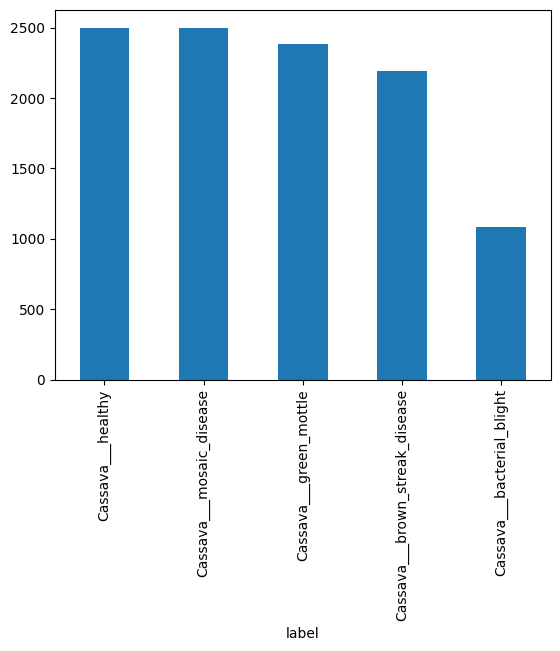

In [9]:
df_balanced['label'].value_counts().plot(kind='bar')
print(df_balanced['label'].value_counts())

The class imbalance is now improved. But still, the class "bacterial_blight" has lesser number of samples than the other classes. Hence, we need to augment a few images of this class. But before that we need to split the data into training, validation and testing sets, such that we only augment data of the training set.

## Split the original dataset into training, validation and testing sets
We split the data from each class proportionately in the ratio 70:20:10 (Training:Validation:Testing)

The function for stratified splitting has been borrowed from [Stackoverflow](https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test#:~:text=Here%20is%20a%20Python%20function,learn's%20function%20train_test_split()%20twice.&text=Below%20is%20a%20complete%20working%20example.). Thanks to the contributor.

In [10]:
def split_stratified_into_train_val_test(df_input, stratify_colname='y',
                                         frac_val=0.15, frac_test=0.25,
                                         random_state=None):
    '''
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    '''
    frac_train = 1.0 - (frac_val + frac_test)    
    if 0.9999 > frac_train + frac_val + frac_test > 1.0:
        raise ValueError('fractions %f, %f, %f do not add up to 1.0' % \
                         (frac_train, frac_val, frac_test))

    if stratify_colname not in df_input.columns:
        raise ValueError('%s is not a column in the dataframe' % (stratify_colname))

    X = df_input # Contains all columns.
    y = df_input[[stratify_colname]] # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                          y,
                                                          stratify=y,
                                                          test_size=(1.0 - frac_train),
                                                          random_state=random_state)

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                      y_temp,
                                                      stratify=y_temp,
                                                      test_size=relative_frac_test,
                                                      random_state=random_state)

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

df_train, df_val, df_test = split_stratified_into_train_val_test(df_balanced, 'label', frac_val=0.2000, frac_test=0.1000)

## Class distribution in each subset
Let's see the number of images in each class for each of the dataframes

Number of images in training dataframe: 7463


<Axes: xlabel='label'>

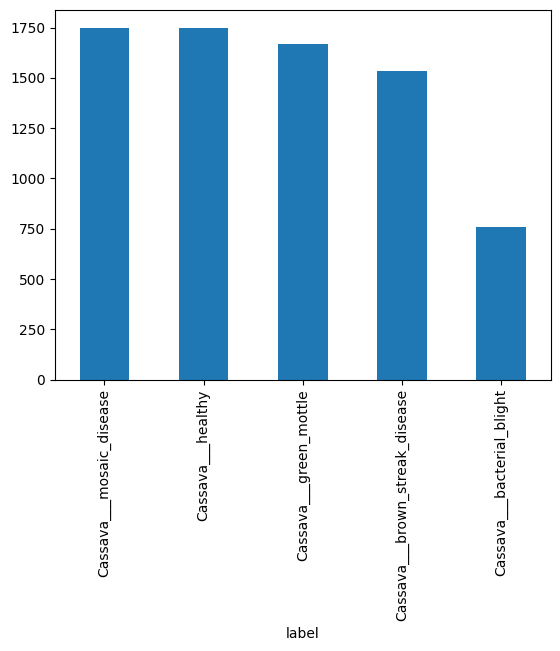

In [11]:
# plot value counts of team in descending order
print("Number of images in training dataframe:", len(df_train))
df_train.label.value_counts().plot(kind='bar')

Number of images in validation dataframe: 2132


<Axes: xlabel='label'>

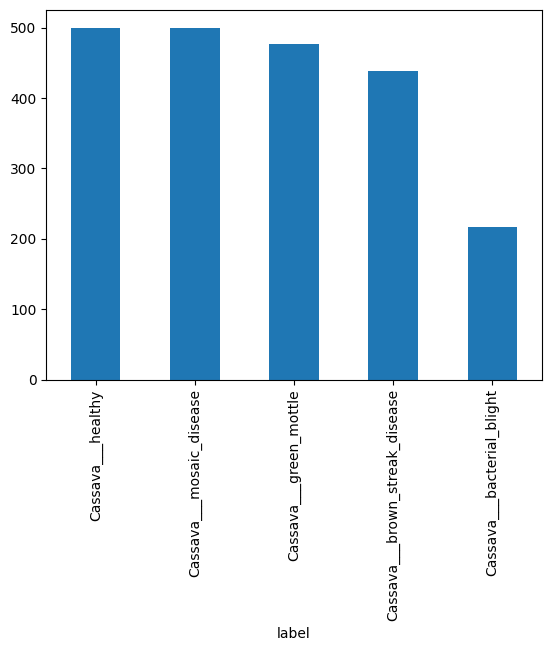

In [12]:
print("Number of images in validation dataframe:", len(df_val))
df_val.label.value_counts().plot(kind='bar')

Number of images in testing dataframe: 1067


<Axes: xlabel='label'>

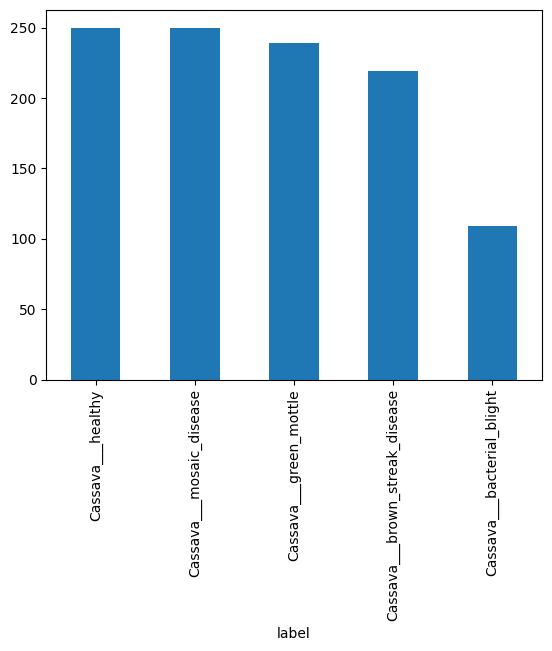

In [13]:
print("Number of images in testing dataframe:", len(df_test))
df_test.label.value_counts().plot(kind='bar')

## Training
### Create Data generators
We create image data generators for the four models that we will use. Each has their own image preprocessing function which has been used for each type of model.
Along with that random horizontal and vertical flipping of images are done to further augment the data.

In [14]:
train_datagen_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing, horizontal_flip=True, vertical_flip=True)
val_datagen_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing)
test_datagen_inception = ImageDataGenerator(preprocessing_function=inception_preprocessing)

train_datagen_densenet = ImageDataGenerator(preprocessing_function=densenet_preprocessing, horizontal_flip=True, vertical_flip=True)
val_datagen_densenet = ImageDataGenerator(preprocessing_function=densenet_preprocessing)
test_datagen_densenet = ImageDataGenerator(preprocessing_function=densenet_preprocessing)

train_datagen_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing, horizontal_flip=True, vertical_flip=True)
val_datagen_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing)
test_datagen_efficientnet = ImageDataGenerator(preprocessing_function=efficientnet_preprocessing)

train_datagen_mobilenet = ImageDataGenerator(preprocessing_function=mobilenet_preprocessing, horizontal_flip=True, vertical_flip=True)
val_datagen_mobilenet = ImageDataGenerator(preprocessing_function=mobilenet_preprocessing)
test_datagen_mobilenet = ImageDataGenerator(preprocessing_function=mobilenet_preprocessing)

### Set Batch size and target image shapes
For training EfficientNet and InceptionV3 models, any image shape can be given. We set the image shape to be `256 x 256 x 3` for training EfficientNet and InceptionV3 models. For DenseNet and MobileNet V2, we set image shape to be `224 x 224 x 3` as the original models were trained in this image image resolution.

In [15]:
BATCH_SIZE = 32
IMG_SHAPE = (256, 256, 3)
num_classes = len(class_names)
IMG_SHAPE_2 = (224, 224, 3)

### Creating Call backs
We define the below callbacks that will be used in training all the models.

In [16]:
# We create a Learning Rate Reducer that will reduce the learning rate by half if the validation loss does not decrease in 4 consecutive epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0000001, verbose = 1)

# We stop the model training if we see no improvement (reduction in validation loss) for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=10)

### Creating Plotting function
To plot the accuracy and loss of training and validation data

In [17]:
def plot_acc_loss(model_history, model_name):
    """
    Plots the Accuracy and Loss of Training and Validation data
    :param model_history: The history object returned by .fit method of the model.
    :param model_name: The name of the model
    """
    
    # Plot the training and validation loss
    plt.plot(model_history.history['loss'], label='train loss')
    plt.plot(model_history.history['val_loss'], label='validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"Loss during training with {model_name}")
    plt.show()
    
    # Plot the training and validation accuracy
    plt.plot(model_history.history['accuracy'], label='train accuracy')
    plt.plot(model_history.history['val_accuracy'], label='validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f"Accuracy during training with {model_name}")
    plt.show()

### Fine tuning EfficientNetB1
Keeping the CNN part fixed, we retrain a new classifier network for the model to fine tune it to this task.

In [14]:
efficientnet_base_model = EfficientNetV2M(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
efficientnet_base_model.trainable = False
efficientnet_base_model_output = efficientnet_base_model.output

x = Flatten()(efficientnet_base_model_output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)
efficientnet_model = Model(efficientnet_base_model.input, outputs)
print("Efficient Net Summary\n", efficientnet_model.summary())

2024-01-17 14:47:22.090451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 14:47:22.124682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 14:47:22.124900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 128, 128, 24)         648       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 128, 128, 24)         96        ['stem_conv[0][0]']           
 n)                                                                                           

### EfficientNet Model compilation
Setting the initial Learning rate to be 0.0003 and using Categorical Crossentropy loss function

In [16]:
LR = 0.0003
efficientnet_model.compile(optimizer = Adam(learning_rate=LR),
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

### Preparing generators

In [26]:
train_generator = train_datagen_efficientnet.flow_from_dataframe(
    dataframe=df_train,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42,
)
valid_generator = train_datagen_efficientnet.flow_from_dataframe(
    dataframe=df_val,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)
test_generator = test_datagen_efficientnet.flow_from_dataframe(
    dataframe=df_test,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

Found 7463 validated image filenames belonging to 5 classes.
Found 2132 validated image filenames belonging to 5 classes.
Found 1067 validated image filenames belonging to 5 classes.


### Training EfficientNet

In [18]:
start = time()
history_efficientnet = efficientnet_model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks=[reduce_lr, early_stopping], verbose=1)
end = time()
print("Training took {} minutes".format((end - start)/60))

Epoch 1/50


2024-01-17 14:48:31.628789: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


117/117 [==============================] - 71s 504ms/step - loss: 1.5353 - accuracy: 0.3206 - val_loss: 1.3752 - val_accuracy: 0.3780 - lr: 3.0000e-04
Epoch 2/50
117/117 [==============================] - 54s 458ms/step - loss: 1.3454 - accuracy: 0.4079 - val_loss: 1.2481 - val_accuracy: 0.4531 - lr: 3.0000e-04
Epoch 3/50
117/117 [==============================] - 57s 483ms/step - loss: 1.2585 - accuracy: 0.4565 - val_loss: 1.1751 - val_accuracy: 0.5094 - lr: 3.0000e-04
Epoch 4/50
117/117 [==============================] - 54s 463ms/step - loss: 1.2197 - accuracy: 0.4927 - val_loss: 1.1551 - val_accuracy: 0.5230 - lr: 3.0000e-04
Epoch 5/50
117/117 [==============================] - 55s 471ms/step - loss: 1.1612 - accuracy: 0.5273 - val_loss: 1.1191 - val_accuracy: 0.5432 - lr: 3.0000e-04
Epoch 6/50
117/117 [==============================] - 54s 458ms/step - loss: 1.1238 - accuracy: 0.5448 - val_loss: 1.0950 - val_accuracy: 0.5549 - lr: 3.0000e-04
Epoch 7/50
117/117 [===================

### Plot the Accuracy and Loss
The accuracy and loss for both training and accuracy is plotted

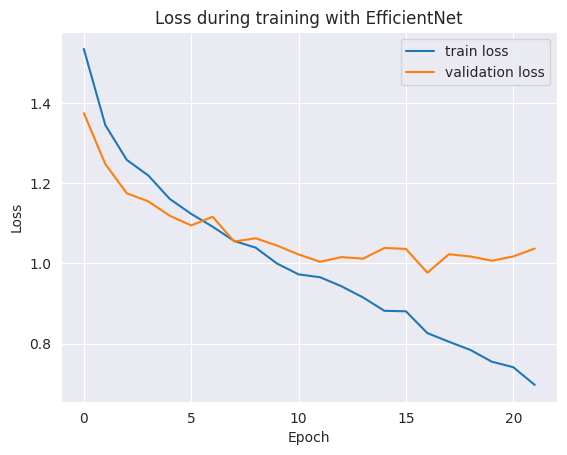

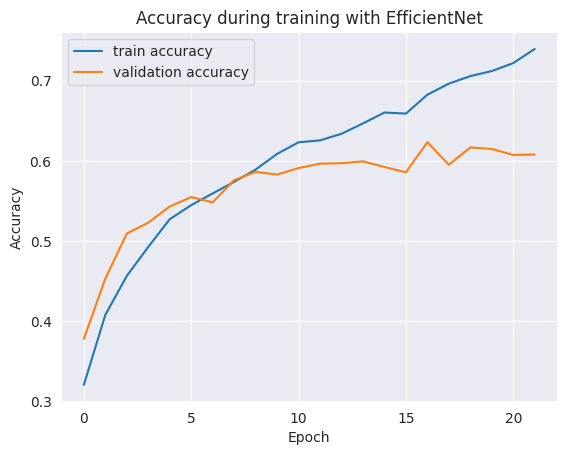

In [22]:
plot_acc_loss(history_efficientnet, model_name="EfficientNet")

### Calculate Accuracy

In [39]:
# Evaluate test set the model
_, accuracy = efficientnet_model.evaluate(test_generator, verbose=2)

# Print the confusion matrix
print(f'Accuracy of EfficientNet: {accuracy*100}%')

1067/1067 - 15s - 15s/epoch - 14ms/step
1067/1067 - 15s - loss: 1.0125 - accuracy: 0.6448 - 15s/epoch - 14ms/step
[[ 53  15   5  35   1]
 [ 14 139  13  38  15]
 [  3  24 147  30  35]
 [ 25  45  18 151  11]
 [  1  15  18  18 198]]
Accuracy: 0.6447985172271729


### Calculate and display confusion matrix

<Axes: >

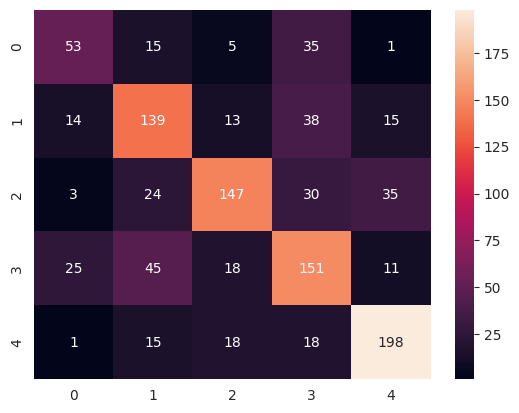

In [42]:
# Get predictions from test set
predictions = efficientnet_model.predict(test_generator, verbose=2)
y_pred = np.argmax(predictions, axis=1).tolist()

# Create the confusion matrix
cm = confusion_matrix(labels=test_generator.labels, predictions=y_pred)

# Display confusion matrix
sns.heatmap(cm, annot=True, fmt='d')

### Fine tuning Inception V3

In [22]:
inception_base_model = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
inception_base_model_output = inception_base_model.output
a = Flatten()(inception_base_model_output)
a = Dense(1024, activation='relu')(a)
a = Dropout(0.2)(a)
a = Dense(512, activation='relu')(a)
a = Dense(256, activation='relu')(a)
a = Dropout(0.2)(a)
a = Dense(128, activation='relu')(a)
a = Dropout(0.1)(a)
a = Dense(32, activation='relu')(a)
inception_outputs = Dense(num_classes, activation='softmax')(a)
inception_model = Model(inception_base_model.input, inception_outputs)
print("Inception V3 Summary\n", inception_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 127, 127, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 127, 127, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 127, 127, 32)         0         ['batch_normalization_94

### Compiling inception model

In [24]:
LR = 0.0003
inception_model.compile(optimizer = Adam(learning_rate=LR),
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

### Preparing generators

In [25]:
train_generator = train_datagen_inception.flow_from_dataframe(
    dataframe=df_train,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42,
)
valid_generator = train_datagen_inception.flow_from_dataframe(
    dataframe=df_val,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)
test_generator = test_datagen_inception.flow_from_dataframe(
    dataframe=df_test,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(256, 256),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

Found 7463 validated image filenames belonging to 5 classes.
Found 2132 validated image filenames belonging to 5 classes.
Found 1067 validated image filenames belonging to 5 classes.


### Training Inception V3 model

In [26]:
print("Training with Inception V3")
start = time()
history_inception = inception_model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks=[early_stopping, reduce_lr])
end = time()
print("Training took {} minutes".format((end - start)/60))

Training with Inception V3
Epoch 1/50


2024-01-17 15:48:21.913537: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


117/117 [==============================] - 101s 623ms/step - loss: 1.5380 - accuracy: 0.2948 - val_loss: 1.9521 - val_accuracy: 0.2955 - lr: 3.0000e-04
Epoch 2/50


2024-01-17 15:49:58.759410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 50332928 bytes after encountering the first element of size 50332928 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


117/117 [==============================] - 48s 411ms/step - loss: 1.1249 - accuracy: 0.5581 - val_loss: 2.4396 - val_accuracy: 0.5244 - lr: 3.0000e-04
Epoch 3/50
117/117 [==============================] - 45s 387ms/step - loss: 0.9182 - accuracy: 0.6700 - val_loss: 1.3007 - val_accuracy: 0.5478 - lr: 3.0000e-04
Epoch 4/50
117/117 [==============================] - 45s 387ms/step - loss: 0.7943 - accuracy: 0.7198 - val_loss: 0.9008 - val_accuracy: 0.6768 - lr: 3.0000e-04
Epoch 5/50
117/117 [==============================] - 46s 391ms/step - loss: 0.7015 - accuracy: 0.7543 - val_loss: 1.2604 - val_accuracy: 0.5891 - lr: 3.0000e-04
Epoch 6/50
117/117 [==============================] - 47s 397ms/step - loss: 0.6364 - accuracy: 0.7808 - val_loss: 0.8117 - val_accuracy: 0.7012 - lr: 3.0000e-04
Epoch 7/50
117/117 [==============================] - 47s 398ms/step - loss: 0.5665 - accuracy: 0.8100 - val_loss: 0.9184 - val_accuracy: 0.6548 - lr: 3.0000e-04
Epoch 8/50
117/117 [===================

### Plot the Accuracy and Loss
The accuracy and loss for both training and accuracy is plotted

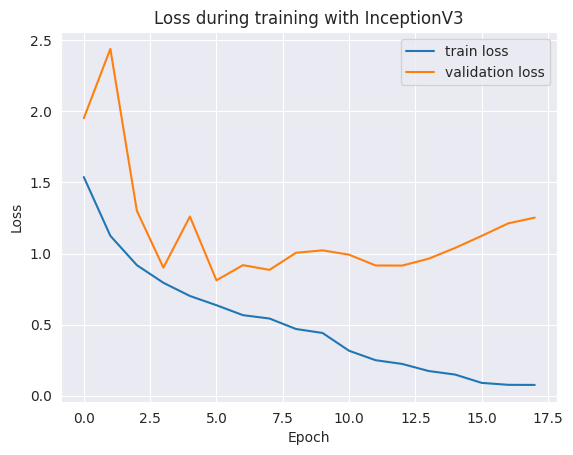

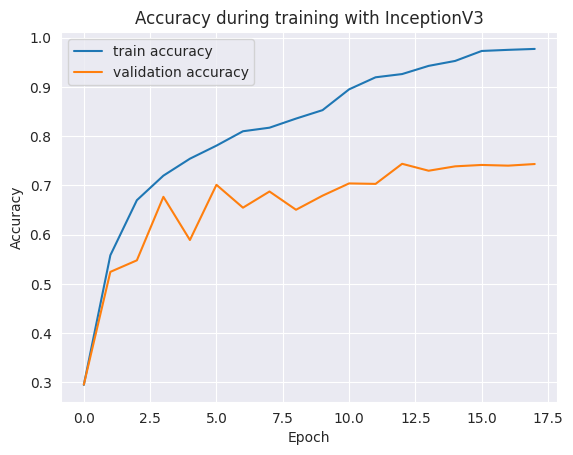

In [27]:
plot_acc_loss(history_inception, model_name="InceptionV3")

### Calculate test set accuracy

In [28]:
# Evaluate test set the model
_, accuracy = inception_model.evaluate(test_generator, verbose=2)

# Print the confusion matrix
print(f'Accuracy of Inception V3: {accuracy*100}%')

1067/1067 - 9s - loss: 1.2619 - accuracy: 0.7545 - 9s/epoch - 9ms/step
Accuracy of Inception V3: 75.44517517089844%


### Calculate and display confusion matrix
The confusion matrix is based on the test set

1067/1067 - 8s - 8s/epoch - 8ms/step


<Axes: >

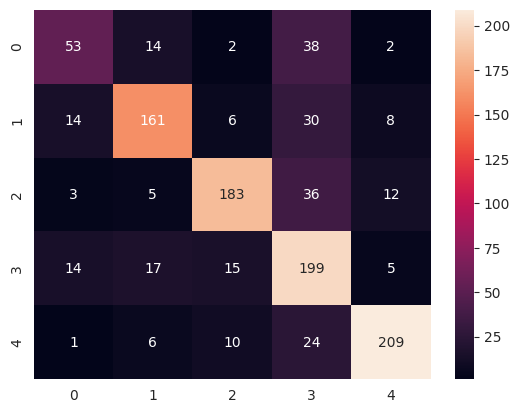

In [29]:
# Get predictions from test set
predictions = inception_model.predict(test_generator, verbose=2)
y_pred = np.argmax(predictions, axis=1).tolist()

# Create the confusion matrix
cm = confusion_matrix(labels=test_generator.labels, predictions=y_pred)

# Display confusion matrix
sns.heatmap(cm, annot=True, fmt='d')

### Finetuning DenseNet

In [19]:
densenet_base_model = DenseNet121(input_shape=IMG_SHAPE_2, include_top=False, weights='imagenet')
densenet_base_model_output = densenet_base_model.output
b = Flatten()(densenet_base_model_output)
b = Dense(1024, activation='relu')(b)
b = Dropout(0.2)(b)
b = Dense(512, activation='relu')(b)
b = Dense(256, activation='relu')(b)
b = Dropout(0.2)(b)
b = Dense(128, activation='relu')(b)
b = Dropout(0.1)(b)
b = Dense(32, activation='relu')(b)
densenet_outputs = Dense(num_classes, activation='softmax')(b)
densenet_model = Model(densenet_base_model.input, densenet_outputs)
print("Densenet Summary\n", densenet_model.summary())

2024-01-17 16:37:35.928447: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 16:37:35.982294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 16:37:35.982560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

### Compiling DenseNet model

In [20]:
LR = 0.0003
densenet_model.compile(optimizer = Adam(learning_rate=LR),
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

### Preparing generators

In [21]:
train_generator = train_datagen_densenet.flow_from_dataframe(
    dataframe=df_train,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42,
)
valid_generator = train_datagen_densenet.flow_from_dataframe(
    dataframe=df_val,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)
test_generator = test_datagen_densenet.flow_from_dataframe(
    dataframe=df_test,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

Found 7463 validated image filenames belonging to 5 classes.
Found 2132 validated image filenames belonging to 5 classes.
Found 1067 validated image filenames belonging to 5 classes.


### Training DenseNet model

In [22]:
print("Training with DenseNet")
start = time()
history_densenet = densenet_model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks=[early_stopping, reduce_lr])
end = time()
print("Training took {} minutes".format((end - start)/60))

Training with DenseNet
Epoch 1/50


2024-01-17 16:37:51.887195: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


234/234 [==============================] - 93s 275ms/step - loss: 1.4391 - accuracy: 0.4387 - val_loss: 1.4903 - val_accuracy: 0.5563 - lr: 3.0000e-04
Epoch 2/50
234/234 [==============================] - 50s 213ms/step - loss: 1.0440 - accuracy: 0.6111 - val_loss: 0.9437 - val_accuracy: 0.6693 - lr: 3.0000e-04
Epoch 3/50
234/234 [==============================] - 50s 213ms/step - loss: 0.8921 - accuracy: 0.6747 - val_loss: 1.3605 - val_accuracy: 0.5535 - lr: 3.0000e-04
Epoch 4/50
234/234 [==============================] - 50s 213ms/step - loss: 0.8402 - accuracy: 0.7086 - val_loss: 0.9043 - val_accuracy: 0.6670 - lr: 3.0000e-04
Epoch 5/50
234/234 [==============================] - 50s 212ms/step - loss: 0.7689 - accuracy: 0.7283 - val_loss: 0.9488 - val_accuracy: 0.6679 - lr: 3.0000e-04
Epoch 6/50
234/234 [==============================] - 50s 213ms/step - loss: 0.7509 - accuracy: 0.7331 - val_loss: 0.9531 - val_accuracy: 0.6759 - lr: 3.0000e-04
Epoch 7/50
234/234 [===================

### Plot the Accuracy and Loss

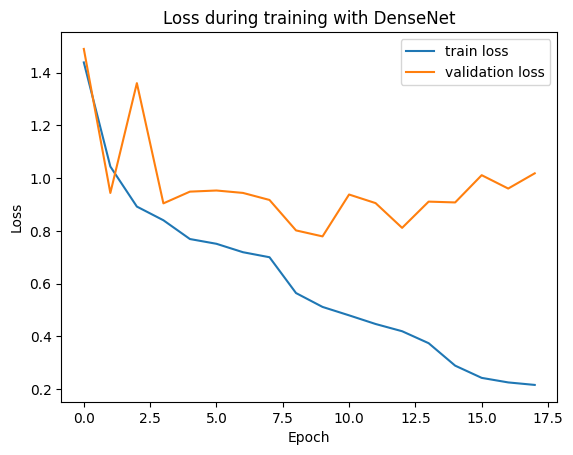

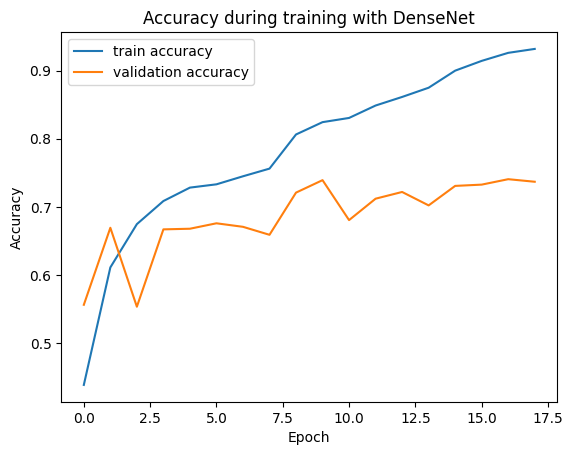

In [23]:
plot_acc_loss(history_densenet, model_name="DenseNet")

### Calculate test set accuracy

In [24]:
# Evaluate test set the model
_, accuracy = densenet_model.evaluate(test_generator, verbose=2)

# Print the confusion matrix
print(f'Accuracy of DenseNet: {accuracy*100:.2f}%')

1067/1067 - 27s - loss: 0.9880 - accuracy: 0.7404 - 27s/epoch - 25ms/step
Accuracy of DenseNet: 74.04%


### Calculate and display confusion matrix
The confusion matrix is based on the test set

1067/1067 - 26s - 26s/epoch - 24ms/step


<Axes: >

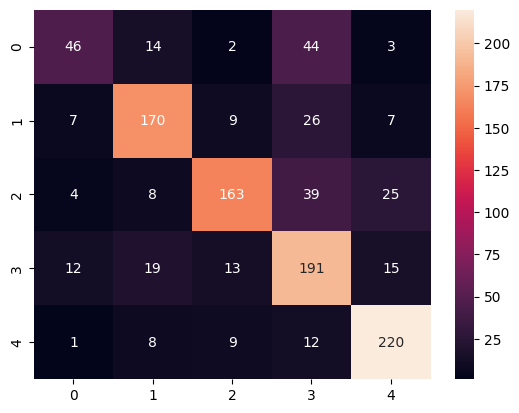

In [25]:
# Get predictions from test set
predictions = densenet_model.predict(test_generator, verbose=2)
y_pred = np.argmax(predictions, axis=1).tolist()

# Create the confusion matrix
cm = confusion_matrix(labels=test_generator.labels, predictions=y_pred)

# Display confusion matrix
sns.heatmap(cm, annot=True, fmt='d')

### Fine tuning MobileNet v2

In [18]:
mobilenet_base_model = MobileNetV2(input_shape=IMG_SHAPE_2, include_top=False, weights='imagenet')
mobilenet_base_model.trainable = False
mobilenet_base_model_output = mobilenet_base_model.output
c = Flatten()(mobilenet_base_model_output)
c = Dense(1024, activation='relu')(c)
c = Dropout(0.2)(c)
c = Dense(512, activation='relu')(c)
c = Dense(256, activation='relu')(c)
c = Dropout(0.2)(c)
c = Dense(128, activation='relu')(c)
c = Dropout(0.1)(c)
c = Dense(32, activation='relu')(c)
mobilenet_outputs = Dense(num_classes, activation='softmax')(c)
mobilenet_model = Model(mobilenet_base_model.input, mobilenet_outputs)
print("Mobilenet V2 Summary\n", mobilenet_model.summary())

2024-01-17 16:57:18.636832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 16:57:18.691440: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-17 16:57:18.691693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

### Compiling MobileNet v2

In [19]:
LR = 0.0003
mobilenet_model.compile(optimizer = Adam(learning_rate=LR),
            loss = CategoricalCrossentropy(),
            metrics=['accuracy'])

### Preparing generators

In [20]:
train_generator = train_datagen_mobilenet.flow_from_dataframe(
    dataframe=df_train,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42,
)
valid_generator = train_datagen_mobilenet.flow_from_dataframe(
    dataframe=df_val,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=42
)
test_generator = test_datagen_mobilenet.flow_from_dataframe(
    dataframe=df_test,
    directory='./',
    x_col="image_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
)

Found 7463 validated image filenames belonging to 5 classes.
Found 2132 validated image filenames belonging to 5 classes.
Found 1067 validated image filenames belonging to 5 classes.


### Training MobileNet v2

In [21]:
print("Training with MobileNet")
start = time()
history_mobilenet = mobilenet_model.fit(train_generator, epochs=50, validation_data=valid_generator, callbacks=[early_stopping, reduce_lr])
end = time()
print("Training took {} minutes".format((end - start)/60))

Training with MobileNet
Epoch 1/50


2024-01-17 16:57:23.970233: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


234/234 [==============================] - 43s 167ms/step - loss: 1.5882 - accuracy: 0.3535 - val_loss: 1.2305 - val_accuracy: 0.4836 - lr: 3.0000e-04
Epoch 2/50
234/234 [==============================] - 37s 159ms/step - loss: 1.2736 - accuracy: 0.4762 - val_loss: 1.1927 - val_accuracy: 0.5042 - lr: 3.0000e-04
Epoch 3/50
234/234 [==============================] - 38s 160ms/step - loss: 1.1503 - accuracy: 0.5338 - val_loss: 1.1200 - val_accuracy: 0.5380 - lr: 3.0000e-04
Epoch 4/50
234/234 [==============================] - 37s 160ms/step - loss: 1.0750 - accuracy: 0.5716 - val_loss: 1.0989 - val_accuracy: 0.5502 - lr: 3.0000e-04
Epoch 5/50
234/234 [==============================] - 38s 163ms/step - loss: 1.0323 - accuracy: 0.5933 - val_loss: 1.1371 - val_accuracy: 0.5553 - lr: 3.0000e-04
Epoch 6/50
234/234 [==============================] - 37s 159ms/step - loss: 0.9705 - accuracy: 0.6177 - val_loss: 1.0614 - val_accuracy: 0.5765 - lr: 3.0000e-04
Epoch 7/50
234/234 [===================

### Plot Accuracy and Loss

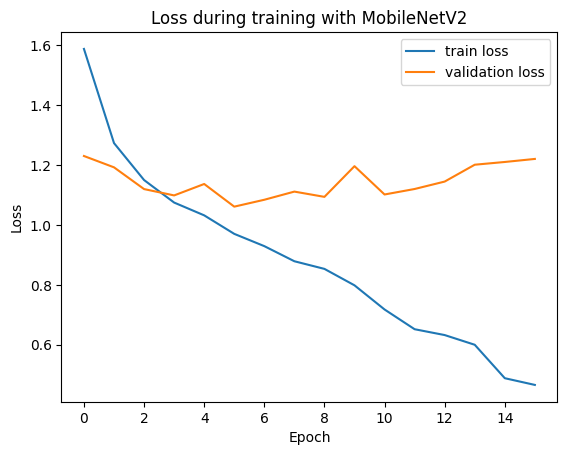

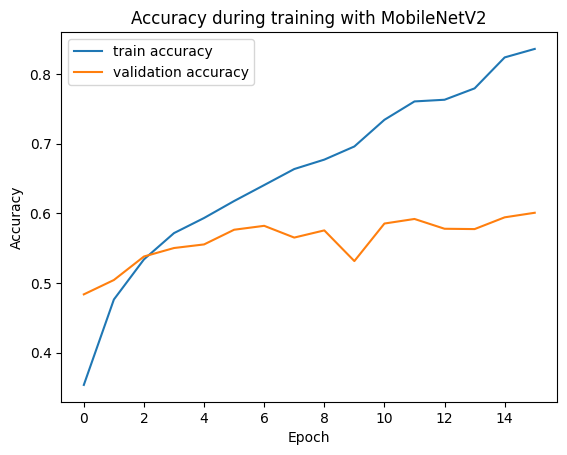

In [22]:
plot_acc_loss(history_mobilenet, model_name="MobileNetV2")

### Calculate test set accuracy

In [23]:
# Evaluate test set the model
_, accuracy = mobilenet_model.evaluate(test_generator, verbose=2)

# Print the confusion matrix
print(f'Accuracy of DenseNet: {accuracy*100:.2f}%')

1067/1067 - 10s - loss: 1.2551 - accuracy: 0.5942 - 10s/epoch - 10ms/step
Accuracy of DenseNet: 59.42%


### Calculate and display confusion matrix
The confusion matrix is based on the test set

1067/1067 - 12s - 12s/epoch - 11ms/step


<Axes: >

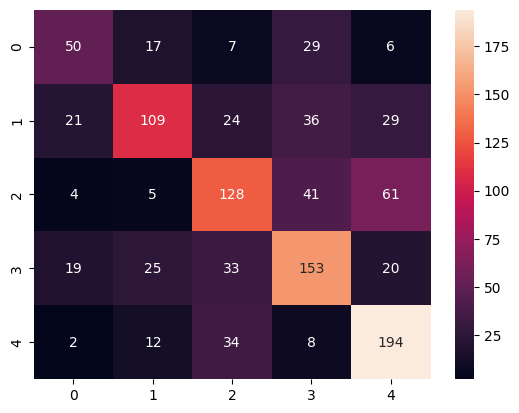

In [24]:
# Get predictions from test set
predictions = mobilenet_model.predict(test_generator, verbose=2)
y_pred = np.argmax(predictions, axis=1).tolist()

# Create the confusion matrix
cm = confusion_matrix(labels=test_generator.labels, predictions=y_pred)

# Display confusion matrix
sns.heatmap(cm, annot=True, fmt='d')

## Comparison of test set accuracy

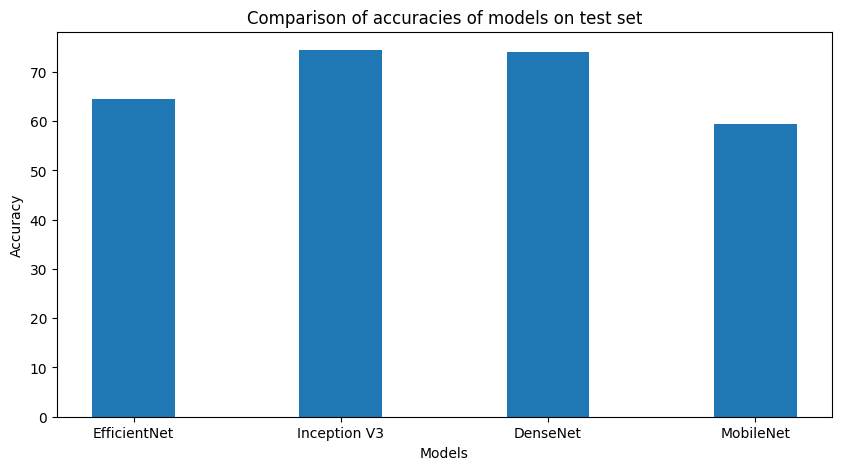

In [25]:
accuracy_efficientnet = 64.48
accuracy_inceptionv3 = 74.44
accuracy_densenet = 74.04
accuracy_mobilenet = 59.52

accuracies = [accuracy_efficientnet, accuracy_inceptionv3, accuracy_densenet, accuracy_mobilenet]
models = ['EfficientNet', 'Inception V3', 'DenseNet', 'MobileNet']

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(models, accuracies, width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of accuracies of models on test set")
plt.show()

## InceptionV3 performed the best for Cassava leaf disease classification task with an accuracy of 74.44%